In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [19]:
df = pd.read_csv('/content/set1.csv')

In [22]:
df.head()

,date,open,high,low,close,volume,adjclose,Date
0,2012-07-23,21.228571,21.639286,20.989643,21.565357,487975600,18.257217,2012-07-23
1,2012-07-24,21.692142,21.774286,21.375357,21.461430,565132400,18.169228,2012-07-24
2,2012-07-27,20.536072,20.922501,20.413929,20.898571,403936400,17.692717,2012-07-27
3,2012-07-30,21.104286,21.408571,20.993570,21.251072,379142400,17.991146,2012-07-30
4,2012-07-31,21.543928,21.846430,21.525715,21.812857,462327600,18.466757,2012-07-31


In [25]:
df['date'] = pd.to_datetime(df.date)


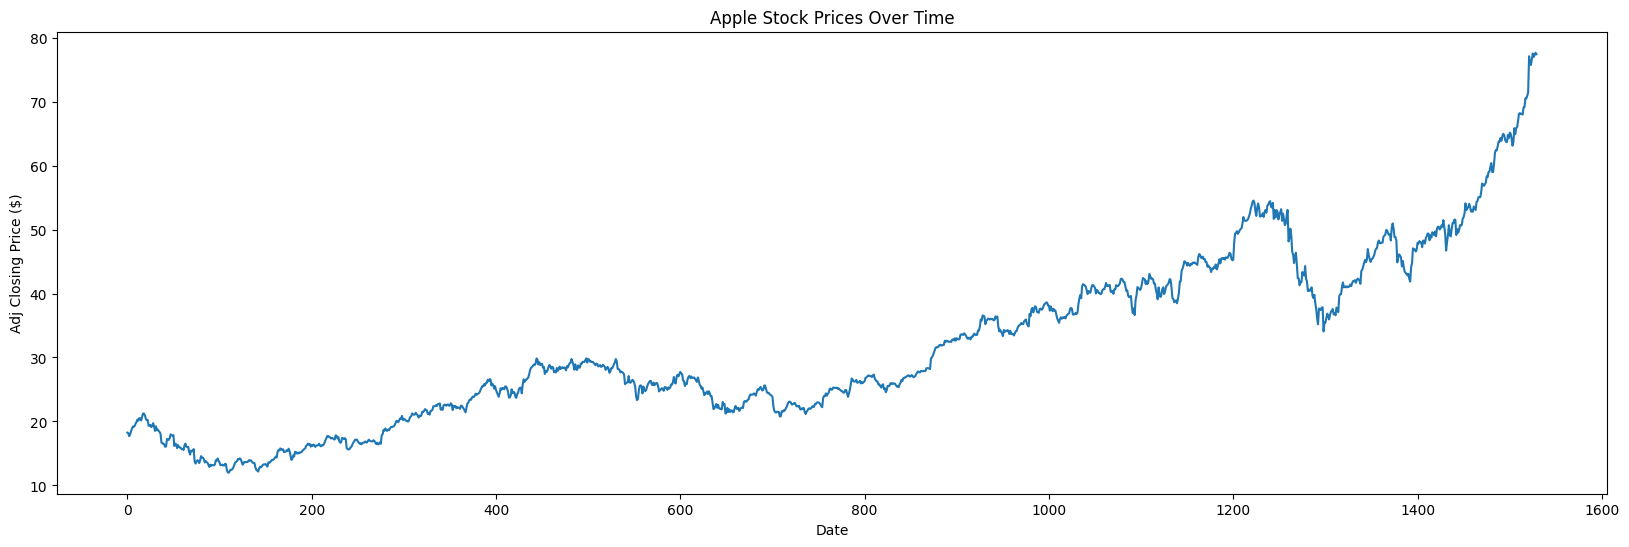

In [27]:
plt.figure(figsize=(20, 6))
plt.plot(df["adjclose"])
plt.xlabel("Date")
plt.ylabel("Adj Closing Price ($)")
plt.title("Apple Stock Prices Over Time")
plt.show()

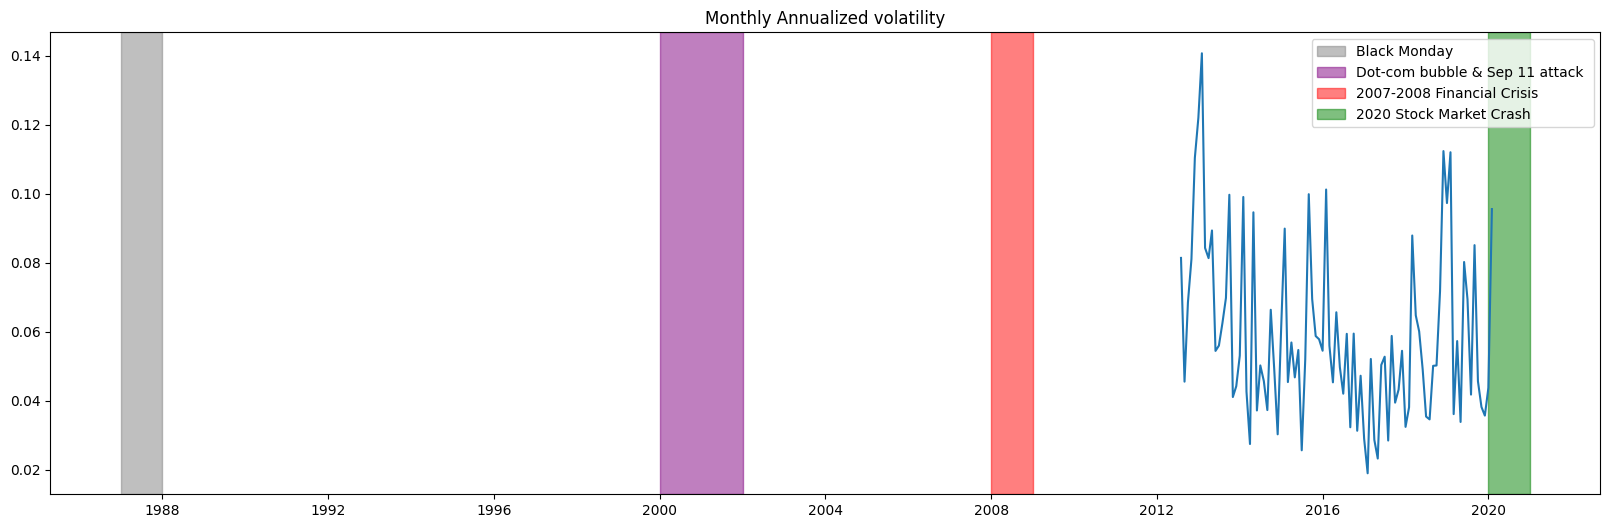

In [28]:
# Set interceptate column as the index
newdf=df.set_index('date')

#To model returns we will use daily % change
daily = newdf['adjclose'].pct_change()
daily.dropna(inplace = True)

#Resample returns per month and take STD as measure of volatility
monthly=daily.resample("M").std()*np.sqrt(12)



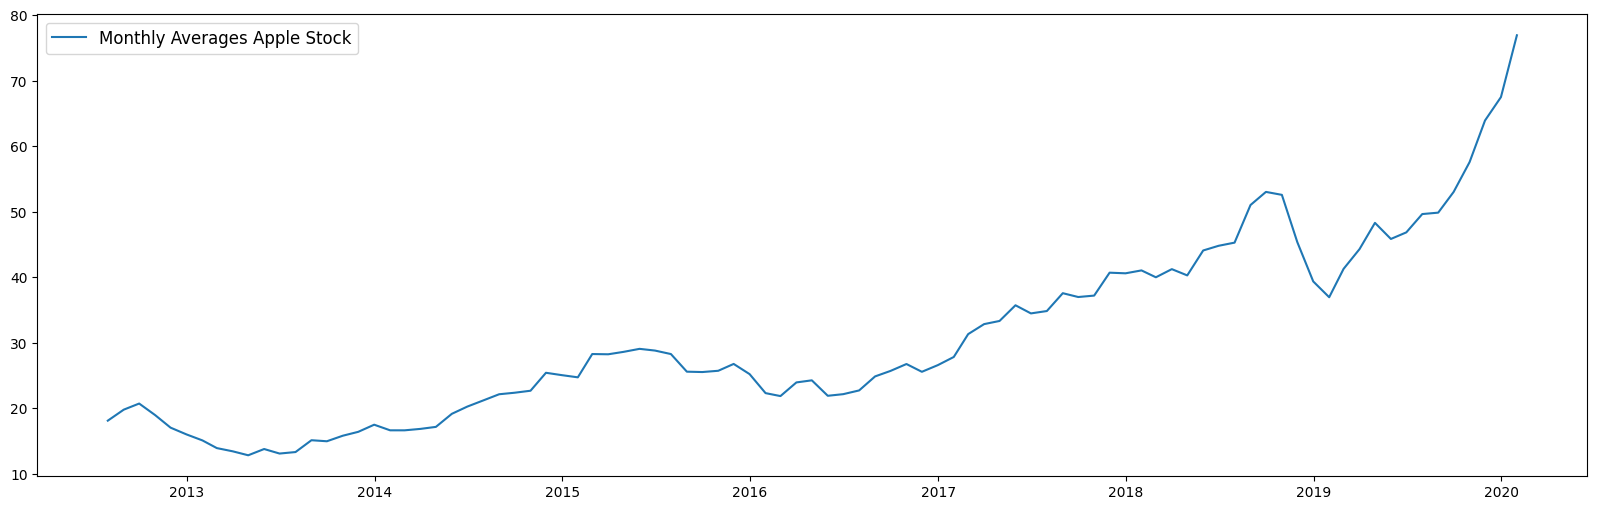

In [29]:
# Resample the data to the monthly level
monthly_mean = newdf['adjclose'].resample('M').mean()
monthly_data = monthly_mean.to_frame()
##Monthly Stock Price
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_data['adjclose'],label='Monthly Averages Apple Stock')
plt.legend(prop={'size': 12})
plt.show()

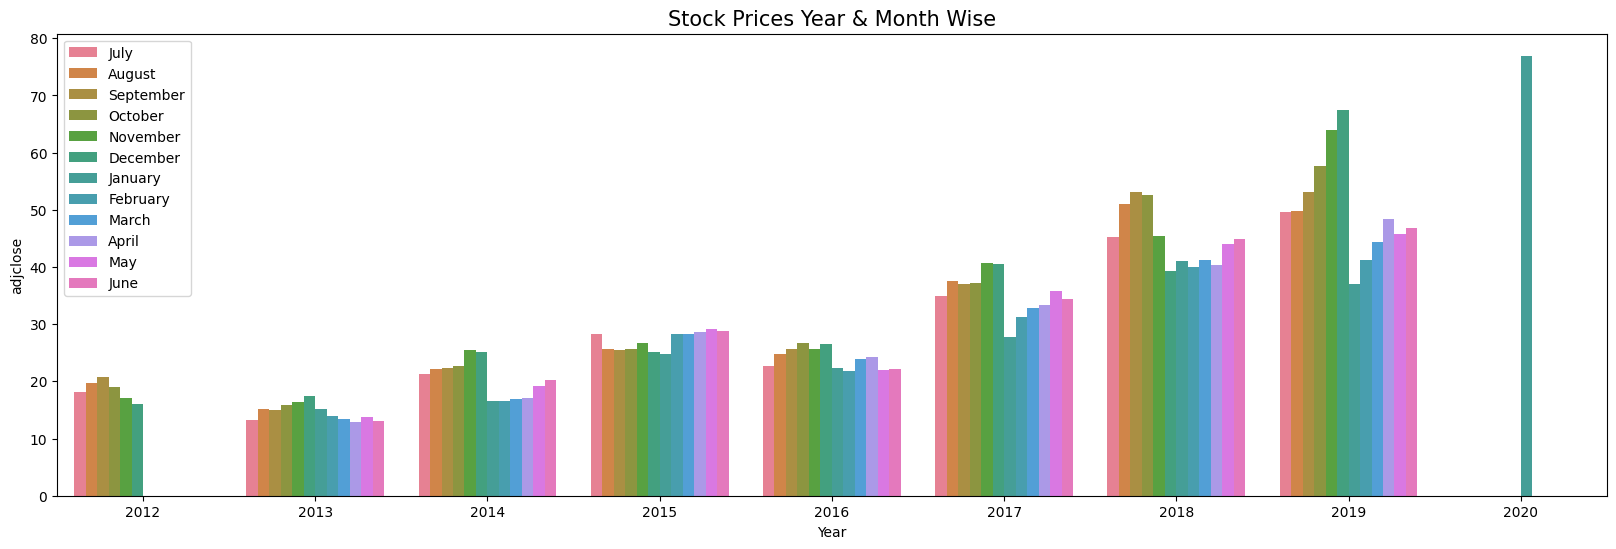

In [31]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['Quarter'] = monthly_data.index.quarter
fig, ax = plt.subplots(figsize=(20,6))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="adjclose",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

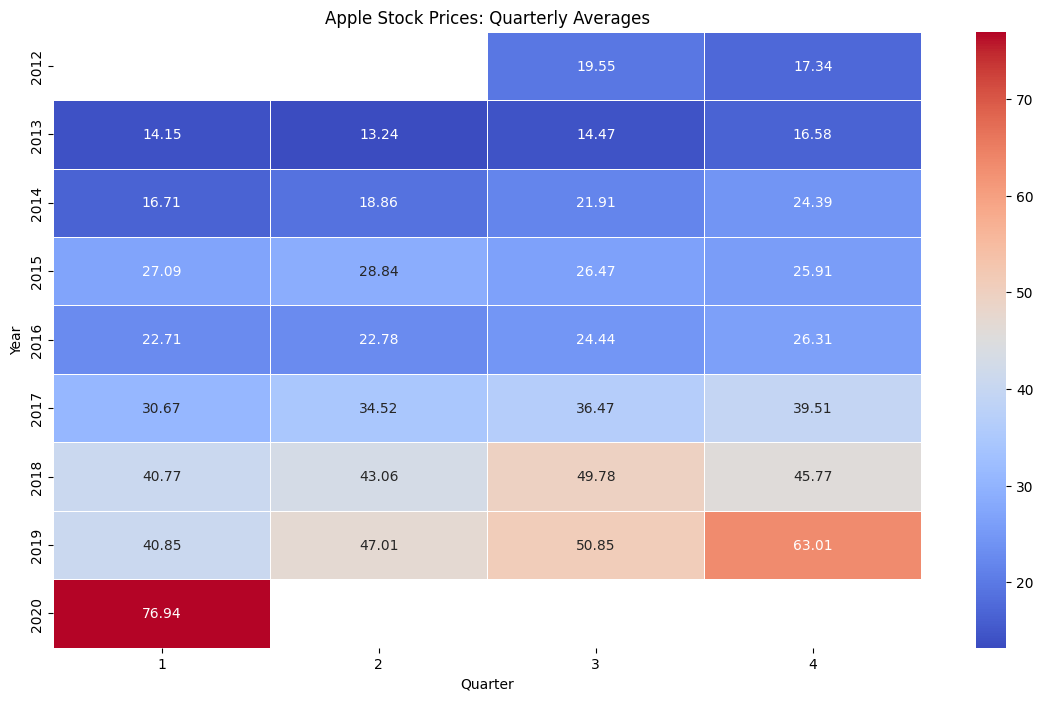

In [32]:
quarter = monthly_data.groupby(["Year", "Quarter"])["adjclose"].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(quarter, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("Apple Stock Prices: Quarterly Averages")
plt.show()

<Figure size 3000x1200 with 0 Axes>

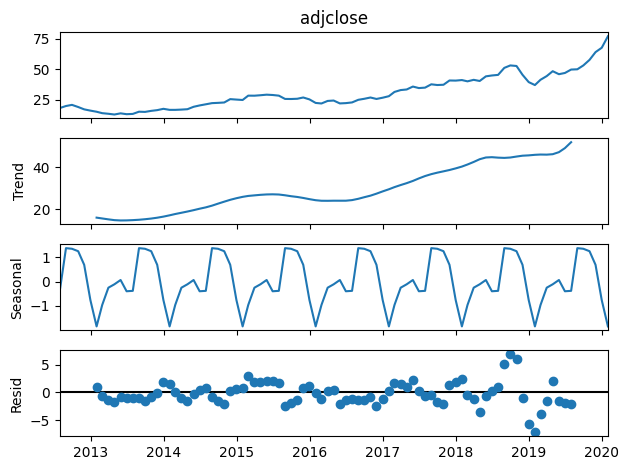

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd

plt.figure(figsize=(30,12))
decomposed_series = sd(monthly_data['adjclose'])
decomposed_series.plot()
plt.show()

<Axes: xlabel='date'>

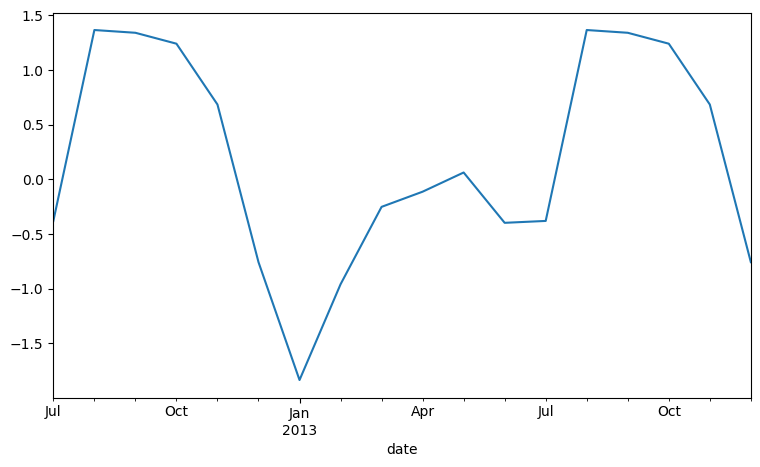

In [36]:
##Drilling Down and Observing Seasonality
fig = plt.figure(figsize=(9,5))
decomposed_series.seasonal['2012':'2013'].plot()

In [37]:
from statsmodels.tsa.stattools import adfuller

def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
   print('\t%s: %.3f' % (key, value))

  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis- Time Series is Stationary')
  else:
    print('Failed to Reject Null Hypothesis- Time Series is Non-Stationary')

ad_fuller_func(monthly_data['adjclose'])

ADF Statistic: 1.745780
p-value: 0.998235
Critical Values:
	1%: -3.506
	5%: -2.895
	10%: -2.584
Failed to Reject Null Hypothesis- Time Series is Non-Stationary


Text(0.5, 0, 'Lags')

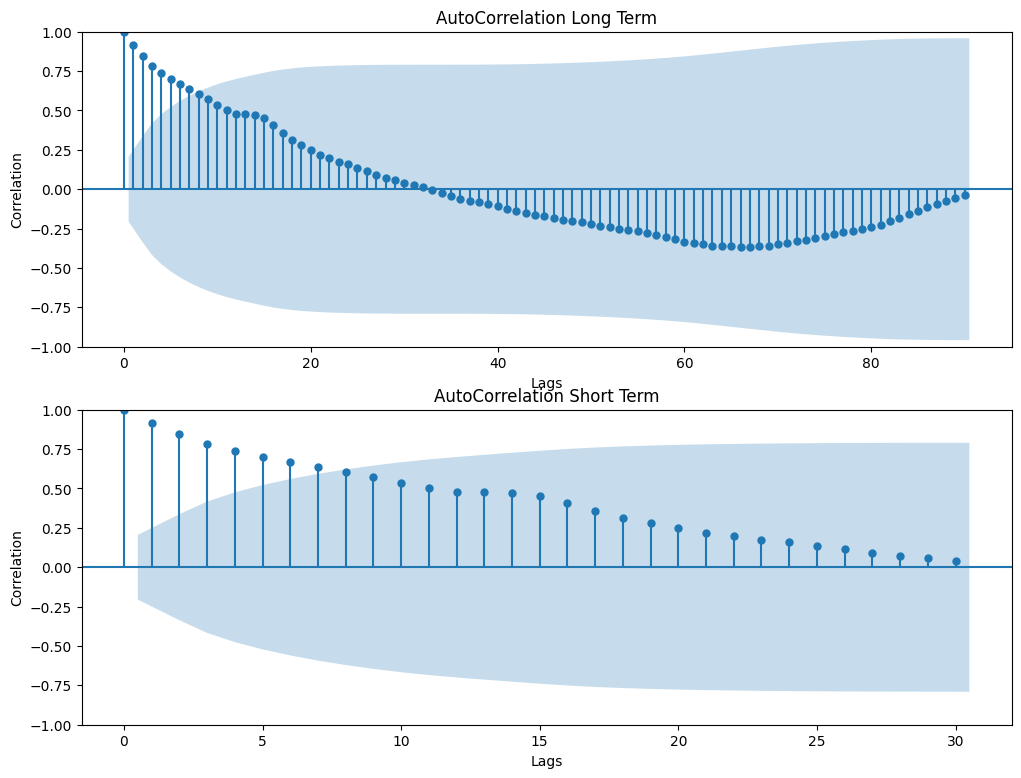

In [41]:
from statsmodels.graphics.tsaplots import plot_acf

fig,(ax1,ax2) = plt.subplots(2,figsize=(12,9))
acf = plot_acf(monthly_data['adjclose'],lags=90,ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
acf = plot_acf(monthly_data['adjclose'],lags=30,ax=ax2)
ax2.set_title('AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

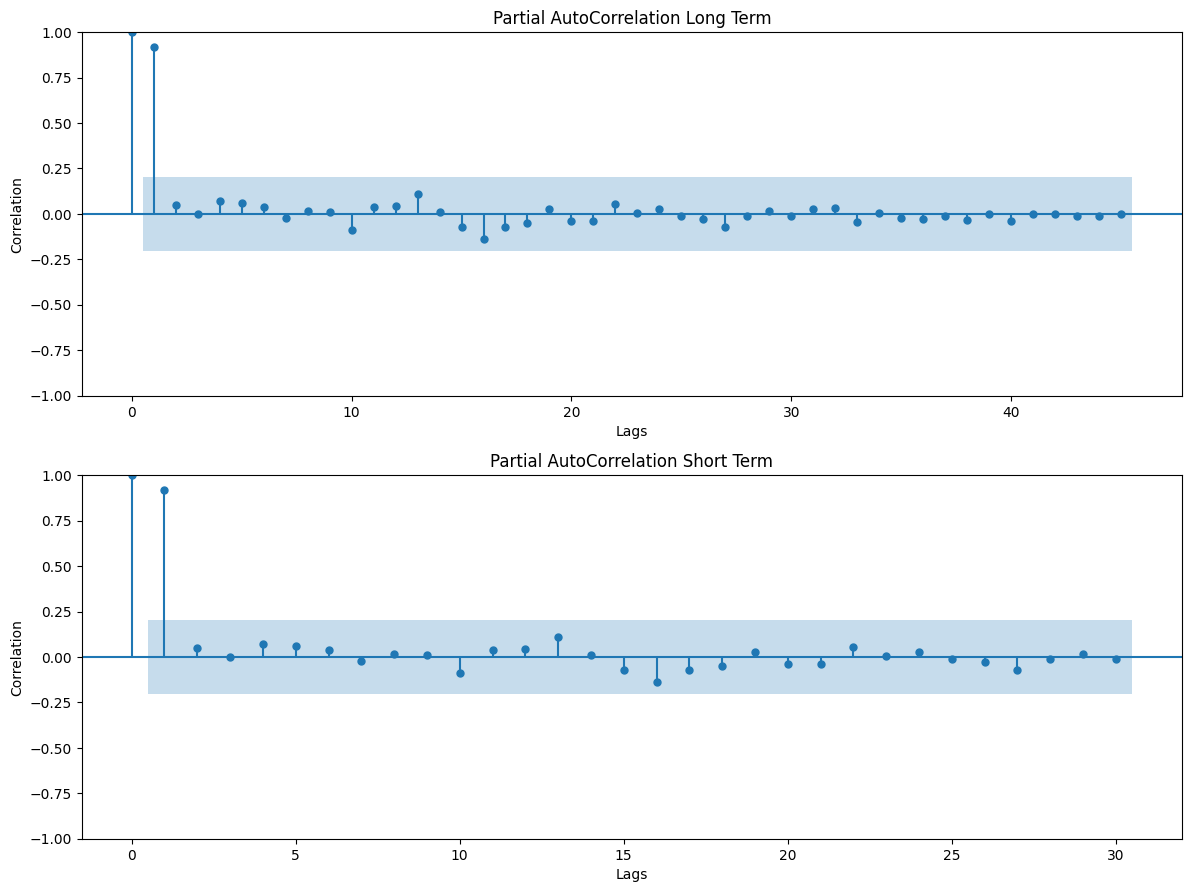

In [45]:
from statsmodels.graphics.tsaplots import plot_pacf

fig,(ax1,ax2) = plt.subplots(2,figsize=(12,9))
pacf = plot_pacf(monthly_data['adjclose'],lags=45,ax=ax1)
ax1.set_title('Partial AutoCorrelation Long Term')
pacf = plot_pacf(monthly_data['adjclose'],lags=30,ax=ax2)
ax2.set_title('Partial AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

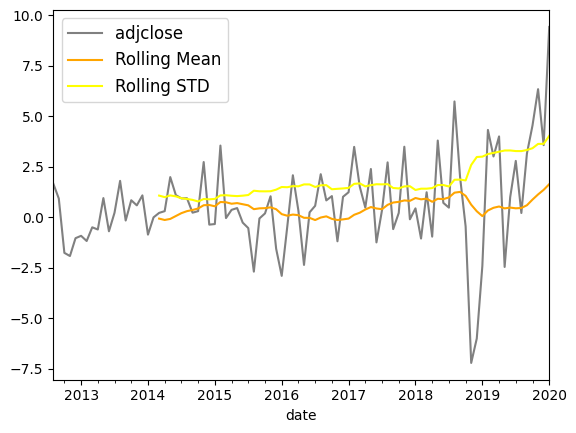

In [46]:
##Differencing By 1
monthly_diff = monthly_data['adjclose'] - monthly_data['adjclose'].shift(1)
monthly_diff[1:].plot(c='grey')
monthly_diff[1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_diff[1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

In [47]:
##Checking if Time Series is Stationary by Running ADF Test
ad_fuller_func(monthly_diff[1:])

ADF Statistic: -5.293121
p-value: 0.000006
Critical Values:
	1%: -3.506
	5%: -2.895
	10%: -2.584
Reject Null Hypothesis- Time Series is Stationary


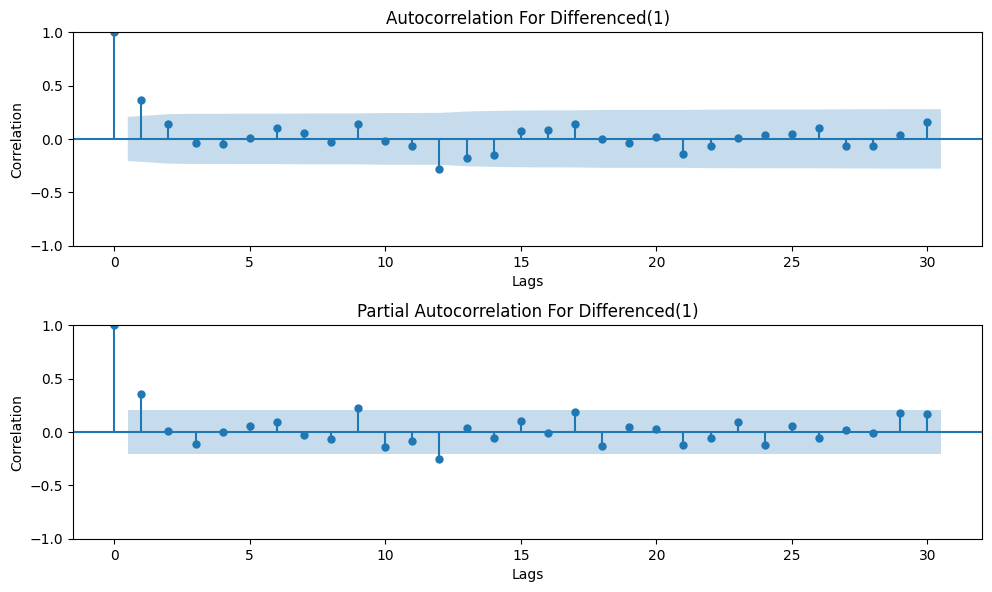

In [48]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,6))
acf = plot_acf(monthly_diff[1:],lags=30,ax=ax1)
pacf = plot_pacf(monthly_diff[1:],lags=30,ax=ax2)
ax1.set_title('Autocorrelation For Differenced(1)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_title('Partial Autocorrelation For Differenced(1)')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

In [49]:
modelling_series = monthly_data['adjclose']
from sklearn.model_selection import train_test_split as split
train,test = split(modelling_series,train_size=0.6,shuffle=False)

In [51]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

list_param = []
list_param_seasonal=[]
list_results_aic=[]

from statsmodels.tsa.statespace.sarimax import SARIMAX
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:479.24883435232664


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:378.8193762926312
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:246.4940217930723
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:265.1621136761591
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1151.5511225199311


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:93.26776759704055
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:214.81690258718714


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:122.73351909733167


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:20.021047199935502
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:271.1662253221429
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:252.25086071690762


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:178.41751524513583
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:201.62970823948226


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1179.056848008713
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:94.51798330745586
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:131.77920578265238


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:122.7738271435095


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:29.858528328695126
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:194.10837162014462


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:196.58504057139058
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:173.68694539051305
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:97.18283550319394
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:97.48534483839477


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:90.12146020661879
ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:33.76782128716612


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:35.76784211759137


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:23.77318845900465
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:405.9642317450731
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:289.91165358671583
ARIMA(0, 0, 1)x(0, 0, 2, 12)12 - AIC:206.48102736486877


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:215.53146673078342


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:976.1689303261819
ARIMA(0, 0, 1)x(0, 1, 2, 12)12 - AIC:78.2237597890219
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:177.25693631435882


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(0, 2, 1, 12)12 - AIC:100.43678201967674
ARIMA(0, 0, 1)x(0, 2, 2, 12)12 - AIC:18.33133975682967
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:226.99894983642267
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:206.71014188670435


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 0, 2, 12)12 - AIC:149.14401826141557
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:167.49988001124558


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1028.3096115471635
ARIMA(0, 0, 1)x(1, 1, 2, 12)12 - AIC:79.41988558864355
ARIMA(0, 0, 1)x(1, 2, 0, 12)12 - AIC:116.1516297289749


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 2, 1, 12)12 - AIC:102.43660435920256


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 2, 2, 12)12 - AIC:25.958790193673863
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:164.2796068913638
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:156.81489691889962


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(2, 0, 2, 12)12 - AIC:150.72299776764098
ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:89.53964400045004
ARIMA(0, 0, 1)x(2, 1, 1, 12)12 - AIC:91.42532705887149


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(2, 1, 2, 12)12 - AIC:80.09572821613773
ARIMA(0, 0, 1)x(2, 2, 0, 12)12 - AIC:34.36566153531106


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(2, 2, 1, 12)12 - AIC:37.2134465207881


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(2, 2, 2, 12)12 - AIC:19.245867705393643
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:346.76966751652617
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:252.21460385137496


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 2)x(0, 0, 2, 12)12 - AIC:179.65080357115764
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:194.87498472536973


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:1041.2347951117276
ARIMA(0, 0, 2)x(0, 1, 2, 12)12 - AIC:69.60242595230837
ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:160.59297229032063


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 2)x(0, 2, 1, 12)12 - AIC:93.02325606909031


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(0, 2, 2, 12)12 - AIC:-16.304212995540535
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:211.93703021683584
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:188.49917038369827


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 2)x(1, 0, 2, 12)12 - AIC:135.62091908926288
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:159.48076226764258
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:1091.648934114112


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:69.63266663711899
ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:110.1472112874855


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 2)x(1, 2, 1, 12)12 - AIC:82.52821118354048


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(1, 2, 2, 12)12 - AIC:-9.27992911121699
ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:154.4299826090267
ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:148.24899563455617


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:140.01243619022136
ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:89.71154213714924
ARIMA(0, 0, 2)x(2, 1, 1, 12)12 - AIC:91.54796733819516


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(2, 1, 2, 12)12 - AIC:70.27281037041705
ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:35.3558871490512


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 2)x(2, 2, 1, 12)12 - AIC:30.948031244313867


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 2)x(2, 2, 2, 12)12 - AIC:-16.674975117248252
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:175.85795232260728
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:139.40704095701844
ARIMA(0, 1, 0)x(0, 0, 2, 12)12 - AIC:104.95924743095301
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:166.8072355854423


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1096.8174829407872
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:66.23114062147789
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:142.73525427116047


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 2, 1, 12)12 - AIC:84.37664185137568
ARIMA(0, 1, 0)x(0, 2, 2, 12)12 - AIC:20.358592523226804
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:143.9199290685403
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:141.20733119658047
ARIMA(0, 1, 0)x(1, 0, 2, 12)12 - AIC:106.77571380696963


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:123.4894594101257


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:977.6377675677924
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:66.53904554726375
ARIMA(0, 1, 0)x(1, 2, 0, 12)12 - AIC:90.7702310009241


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(1, 2, 1, 12)12 - AIC:86.65766870140114
ARIMA(0, 1, 0)x(1, 2, 2, 12)12 - AIC:24.894742635443386
ARIMA(0, 1, 0)x(2, 0, 0, 12)12 - AIC:106.57864654414333
ARIMA(0, 1, 0)x(2, 0, 1, 12)12 - AIC:107.41607613449503


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(2, 0, 2, 12)12 - AIC:104.12356557194926
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:73.61007640637467
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:72.48207064822454


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:64.17103935464125
ARIMA(0, 1, 0)x(2, 2, 0, 12)12 - AIC:31.780182692603606


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(2, 2, 1, 12)12 - AIC:33.78016189435003


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(2, 2, 2, 12)12 - AIC:24.202317244831683
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:173.00044595413002
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:137.67200025709437


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(0, 0, 2, 12)12 - AIC:103.89222427055006
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:163.92220884513026


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:771.4346884538545
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:66.95478007451733
ARIMA(0, 1, 1)x(0, 2, 0, 12)12 - AIC:139.36596240289654


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(0, 2, 1, 12)12 - AIC:81.71339850996655
ARIMA(0, 1, 1)x(0, 2, 2, 12)12 - AIC:17.23349509583168
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:145.008402380764
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:139.58877964453146


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 0, 2, 12)12 - AIC:105.77844051311035
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:125.12491554280254


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:884.9237845877161
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:66.02211384475751
ARIMA(0, 1, 1)x(1, 2, 0, 12)12 - AIC:92.45011523415639


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 2, 1, 12)12 - AIC:84.28372750926012


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 2, 2, 12)12 - AIC:21.920675134790297
ARIMA(0, 1, 1)x(2, 0, 0, 12)12 - AIC:107.90811627355212
ARIMA(0, 1, 1)x(2, 0, 1, 12)12 - AIC:108.26337524366281


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(2, 0, 2, 12)12 - AIC:104.73206100734606
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:74.59376119267974
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:74.11448158991448


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:57.74373035656173
ARIMA(0, 1, 1)x(2, 2, 0, 12)12 - AIC:31.375162532881653


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(2, 2, 1, 12)12 - AIC:33.37517127507799


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(2, 2, 2, 12)12 - AIC:-10.248268027663048
ARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:170.29589050752514
ARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC:135.97891417251338
ARIMA(0, 1, 2)x(0, 0, 2, 12)12 - AIC:101.08878784429703
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:160.16410013967598


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:1253.4675074014317
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:65.93984166428399
ARIMA(0, 1, 2)x(0, 2, 0, 12)12 - AIC:135.43842539034307


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 2)x(0, 2, 1, 12)12 - AIC:79.40965808277203
ARIMA(0, 1, 2)x(0, 2, 2, 12)12 - AIC:-3.595626413439284
ARIMA(0, 1, 2)x(1, 0, 0, 12)12 - AIC:146.51616742822807
ARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:137.88319361299344


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 2)x(1, 0, 2, 12)12 - AIC:102.59403626341933
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:127.12483722684398


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:1362.0792091640915
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:63.80821030754971
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:94.03703139562853


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:81.6031197067329


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:4.007847514300147
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:107.43274313276841
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:108.2694153126812


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:100.65279065079538
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:70.58444190110448
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:70.54827720829638


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:55.41960162092493
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:31.522456366155286


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:33.52247374823393


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:-2.8678964365394677
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:198.21084882183902
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:157.98173057782188
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:117.52508755528113
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:180.62138636584743


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:1338.2995246778132
ARIMA(0, 2, 0)x(0, 1, 2, 12)12 - AIC:72.05397249369072
ARIMA(0, 2, 0)x(0, 2, 0, 12)12 - AIC:149.49401493081228
ARIMA(0, 2, 0)x(0, 2, 1, 12)12 - AIC:87.20859021153333


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(0, 2, 2, 12)12 - AIC:16.17578543210775
ARIMA(0, 2, 0)x(1, 0, 0, 12)12 - AIC:162.37016106207528


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(1, 0, 1, 12)12 - AIC:160.2343649044422
ARIMA(0, 2, 0)x(1, 0, 2, 12)12 - AIC:119.52398307414542
ARIMA(0, 2, 0)x(1, 1, 0, 12)12 - AIC:135.73597096301825


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:1148.7511954975726
ARIMA(0, 2, 0)x(1, 1, 2, 12)12 - AIC:74.44155799868308
ARIMA(0, 2, 0)x(1, 2, 0, 12)12 - AIC:93.47725787251193


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(1, 2, 1, 12)12 - AIC:90.00968603120381


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(1, 2, 2, 12)12 - AIC:17.799432748422966
ARIMA(0, 2, 0)x(2, 0, 0, 12)12 - AIC:118.94880870688237
ARIMA(0, 2, 0)x(2, 0, 1, 12)12 - AIC:119.1207330575038


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(2, 0, 2, 12)12 - AIC:117.38130240001468
ARIMA(0, 2, 0)x(2, 1, 0, 12)12 - AIC:77.3897637299868
ARIMA(0, 2, 0)x(2, 1, 1, 12)12 - AIC:77.89843661793446


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(2, 1, 2, 12)12 - AIC:74.17383928484124
ARIMA(0, 2, 0)x(2, 2, 0, 12)12 - AIC:26.830143665127316


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(2, 2, 1, 12)12 - AIC:28.830144333254818


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(2, 2, 2, 12)12 - AIC:19.7994304165145
ARIMA(0, 2, 1)x(0, 0, 0, 12)12 - AIC:172.7387061286065
ARIMA(0, 2, 1)x(0, 0, 1, 12)12 - AIC:136.8710323000466


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 1)x(0, 0, 2, 12)12 - AIC:103.79362982430338
ARIMA(0, 2, 1)x(0, 1, 0, 12)12 - AIC:160.05474681618483
ARIMA(0, 2, 1)x(0, 1, 1, 12)12 - AIC:1192.31420898967
ARIMA(0, 2, 1)x(0, 1, 2, 12)12 - AIC:63.322975212368036


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 1)x(0, 2, 0, 12)12 - AIC:134.1738380197819
ARIMA(0, 2, 1)x(0, 2, 1, 12)12 - AIC:78.87998283448738


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 1)x(0, 2, 2, 12)12 - AIC:-6.694319611282648
ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:144.36442765784085


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:139.4699234706981
ARIMA(0, 2, 1)x(1, 0, 2, 12)12 - AIC:105.6758110039594
ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:125.38515143604768
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:1196.638182322431


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 1)x(1, 1, 2, 12)12 - AIC:63.54514080490675
ARIMA(0, 2, 1)x(1, 2, 0, 12)12 - AIC:88.65565310452227


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 1)x(1, 2, 1, 12)12 - AIC:80.6376204723076


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 1)x(1, 2, 2, 12)12 - AIC:-2.7280036312590923
ARIMA(0, 2, 1)x(2, 0, 0, 12)12 - AIC:107.71972067865877
ARIMA(0, 2, 1)x(2, 0, 1, 12)12 - AIC:109.54545919332423
ARIMA(0, 2, 1)x(2, 0, 2, 12)12 - AIC:102.3156114641476


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 1)x(2, 1, 0, 12)12 - AIC:75.32065720040902
ARIMA(0, 2, 1)x(2, 1, 1, 12)12 - AIC:74.75595308108508


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 1)x(2, 1, 2, 12)12 - AIC:64.0551381544432
ARIMA(0, 2, 1)x(2, 2, 0, 12)12 - AIC:26.342656356442536


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 1)x(2, 2, 1, 12)12 - AIC:22.020783883608672


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1)x(2, 2, 2, 12)12 - AIC:-3.304467893782597
ARIMA(0, 2, 2)x(0, 0, 0, 12)12 - AIC:169.89677917783166
ARIMA(0, 2, 2)x(0, 0, 1, 12)12 - AIC:135.5996689849586


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 2)x(0, 0, 2, 12)12 - AIC:100.4356473204978
ARIMA(0, 2, 2)x(0, 1, 0, 12)12 - AIC:157.9407838131528


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 2)x(0, 1, 1, 12)12 - AIC:1112.923712719857
ARIMA(0, 2, 2)x(0, 1, 2, 12)12 - AIC:63.739286267039056
ARIMA(0, 2, 2)x(0, 2, 0, 12)12 - AIC:132.00807934148844


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 2)x(0, 2, 1, 12)12 - AIC:76.0654043689133


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 2)x(0, 2, 2, 12)12 - AIC:3.049616284202415
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:145.8824605037927


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:138.15794337049823
ARIMA(0, 2, 2)x(1, 0, 2, 12)12 - AIC:101.86197610078975
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:127.0115512536546


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:1117.3746996007396
ARIMA(0, 2, 2)x(1, 1, 2, 12)12 - AIC:63.071535138991855
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:90.55417579880029


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 2)x(1, 2, 1, 12)12 - AIC:77.69929356115514


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 2)x(1, 2, 2, 12)12 - AIC:5.396407876743541
ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:109.1518600486101
ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:110.8376226087903


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 2)x(2, 0, 2, 12)12 - AIC:100.88281075691536
ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:75.75190425099274
ARIMA(0, 2, 2)x(2, 1, 1, 12)12 - AIC:75.92059167539034


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 2)x(2, 1, 2, 12)12 - AIC:55.13129720331497
ARIMA(0, 2, 2)x(2, 2, 0, 12)12 - AIC:26.689288097047285


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 2)x(2, 2, 1, 12)12 - AIC:24.01725828351077


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 2, 2, 12)12 - AIC:7.979728974259129
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:181.39195608609373
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:143.60805817853793
ARIMA(1, 0, 0)x(0, 0, 2, 12)12 - AIC:109.2143413777345


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:170.59775510525157
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1170.5435422758035


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(0, 1, 2, 12)12 - AIC:71.60586584077211
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:147.04917427922254


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(0, 2, 1, 12)12 - AIC:91.32658192033185
ARIMA(1, 0, 0)x(0, 2, 2, 12)12 - AIC:21.40778610564466
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:144.25455983140273
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:145.59328610316152


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(1, 0, 2, 12)12 - AIC:111.20843119157834
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:124.55289185057606


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1224.5497252625569
ARIMA(1, 0, 0)x(1, 1, 2, 12)12 - AIC:73.07641265617727
ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:91.82871098931291


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(1, 2, 1, 12)12 - AIC:93.47375075623317


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 2, 2, 12)12 - AIC:23.688270309879286
ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:107.04904901454496
ARIMA(1, 0, 0)x(2, 0, 1, 12)12 - AIC:108.5280958209682


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(2, 0, 2, 12)12 - AIC:109.80816808611713
ARIMA(1, 0, 0)x(2, 1, 0, 12)12 - AIC:72.07070403332628
ARIMA(1, 0, 0)x(2, 1, 1, 12)12 - AIC:72.7118288118248


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(2, 1, 2, 12)12 - AIC:74.2240315677956
ARIMA(1, 0, 0)x(2, 2, 0, 12)12 - AIC:21.39732532606933


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(2, 2, 1, 12)12 - AIC:23.397348164873506


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(2, 2, 2, 12)12 - AIC:25.397348883627355
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:177.6676943074729
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:140.97558926973144


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(0, 0, 2, 12)12 - AIC:108.07331018624278
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:167.7540384868176


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1150.1297167068137
ARIMA(1, 0, 1)x(0, 1, 2, 12)12 - AIC:66.51807153625562
ARIMA(1, 0, 1)x(0, 2, 0, 12)12 - AIC:143.89070428023354


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(0, 2, 1, 12)12 - AIC:87.5847401918537


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 2, 2, 12)12 - AIC:14.10070148618205
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:145.79472223010293
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:142.7976644734655


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(1, 0, 2, 12)12 - AIC:109.5912962848679
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:126.0796727116914


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1202.3512444137743
ARIMA(1, 0, 1)x(1, 1, 2, 12)12 - AIC:62.95406614357028
ARIMA(1, 0, 1)x(1, 2, 0, 12)12 - AIC:93.30809990107045


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(1, 2, 1, 12)12 - AIC:90.09336040962569


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 2, 2, 12)12 - AIC:16.00193874418749
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:108.84474137493847
ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC:109.78668319097471


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC:98.94122299763615
ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:69.29149795956994
ARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:67.5829048907101


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC:65.24035265063472
ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:23.231793930794165


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:25.231864683258646


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:21.147641741741975
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:176.3644467375117
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:138.55646484041426


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:105.25821578694287
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:165.49097872080836


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:1044.193633286233
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:59.99078229818207
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:140.33178544338327


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:85.37120604393293


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:11.110910309270942
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:146.6232227792805
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:140.0311445743898


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:107.23176713419488
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:128.0600662020785


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:1094.6154813864234
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:59.226632538331415
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:94.61076394244313


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:85.75620617599071


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:-4.802106405358106


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:102.94140192456759


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:105.55732634688309


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:94.87598285624948
ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:70.30566974586822
ARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:70.1039615256986


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:61.2012165699473
ARIMA(1, 0, 2)x(2, 2, 0, 12)12 - AIC:23.381431608737934


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 2)x(2, 2, 1, 12)12 - AIC:25.373808355551596


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 2)x(2, 2, 2, 12)12 - AIC:-9.098637799505209
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:175.8736779050187
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:140.70241980554658
ARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:106.68671894818826
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:167.0970295087709


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1092.0549018268848
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:68.10893345284205
ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:143.32894457091993
ARIMA(1, 1, 0)x(0, 2, 1, 12)12 - AIC:85.74566077629123


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(0, 2, 2, 12)12 - AIC:20.840841620125165
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:140.64252193429945
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:142.41349270738593


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(1, 0, 2, 12)12 - AIC:108.55018650301477
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:121.8165967206887


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1208.8750729461449
ARIMA(1, 1, 0)x(1, 1, 2, 12)12 - AIC:68.46692607620567
ARIMA(1, 1, 0)x(1, 2, 0, 12)12 - AIC:87.01799284680847


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(1, 2, 1, 12)12 - AIC:88.36631912973985
ARIMA(1, 1, 0)x(1, 2, 2, 12)12 - AIC:25.53710967265275
ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:103.94243753467703
ARIMA(1, 1, 0)x(2, 0, 1, 12)12 - AIC:105.70830279421149


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(2, 0, 2, 12)12 - AIC:107.33812274839191
ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:66.26957468677409
ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:64.79777451525493


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(2, 1, 2, 12)12 - AIC:66.1709615584735
ARIMA(1, 1, 0)x(2, 2, 0, 12)12 - AIC:20.114741701104734


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(2, 2, 1, 12)12 - AIC:22.114759886483178


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(2, 2, 2, 12)12 - AIC:24.114760669732902
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:174.9045380909926
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:137.72804669008252


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(0, 0, 2, 12)12 - AIC:104.68782022289378
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:164.7206152052285


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:993.8422621088716
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:66.95897023838472
ARIMA(1, 1, 1)x(0, 2, 0, 12)12 - AIC:139.84239481122844


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(0, 2, 1, 12)12 - AIC:83.79706089452135


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 2, 2, 12)12 - AIC:2.3444373197873
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:141.83531427168504
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:139.3874872369341


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(1, 0, 2, 12)12 - AIC:106.67453482654005
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:123.78089344860814


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1106.5656663829598
ARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:67.27497326105987
ARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:87.79166851771473


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(1, 2, 1, 12)12 - AIC:84.49016616944444


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 2, 2, 12)12 - AIC:10.08813393661055
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:105.75588069239156
ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:107.0272414189773


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(2, 0, 2, 12)12 - AIC:105.21190513236365
ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:63.372843198141844
ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:63.20965732713026


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:59.38922334186011
ARIMA(1, 1, 1)x(2, 2, 0, 12)12 - AIC:22.50787436586732


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(2, 2, 1, 12)12 - AIC:21.358554935531053


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(2, 2, 2, 12)12 - AIC:-8.626608889697987
ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:171.6698508764879
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:137.25954458819962
ARIMA(1, 1, 2)x(0, 0, 2, 12)12 - AIC:102.17893878116992


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:161.16553993303867


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:706.6793478212912
ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:68.03983245668282
ARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:136.52758633059142


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 2)x(0, 2, 1, 12)12 - AIC:81.65176638586047


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(0, 2, 2, 12)12 - AIC:3.36916832470601
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:144.11454225406953
ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:139.19272800567518


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 2)x(1, 0, 2, 12)12 - AIC:102.24974020154463
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:125.76054155788269
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:1181.2926142613867


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:65.79792843710007
ARIMA(1, 1, 2)x(1, 2, 0, 12)12 - AIC:90.07337182137556


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 2)x(1, 2, 1, 12)12 - AIC:81.93171552320192


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(1, 2, 2, 12)12 - AIC:2.238047326997087
ARIMA(1, 1, 2)x(2, 0, 0, 12)12 - AIC:104.3671782329647
ARIMA(1, 1, 2)x(2, 0, 1, 12)12 - AIC:106.12000048674653


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 2)x(2, 0, 2, 12)12 - AIC:102.64738744084018
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:61.44632083423936
ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:61.15376020090196


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 2)x(2, 1, 2, 12)12 - AIC:57.082102354770576
ARIMA(1, 1, 2)x(2, 2, 0, 12)12 - AIC:12.382880452708944


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 2)x(2, 2, 1, 12)12 - AIC:14.38526934555589


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(2, 2, 2, 12)12 - AIC:1.6209284478526413
ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:194.3077723869357
ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:154.9912931132659


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 0)x(0, 0, 2, 12)12 - AIC:116.62862034048146
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:174.35450952843283
ARIMA(1, 2, 0)x(0, 1, 1, 12)12 - AIC:1239.0094261023412


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 0)x(0, 1, 2, 12)12 - AIC:72.4990946911485
ARIMA(1, 2, 0)x(0, 2, 0, 12)12 - AIC:144.34316517854188


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 0)x(0, 2, 1, 12)12 - AIC:86.23950943603398
ARIMA(1, 2, 0)x(0, 2, 2, 12)12 - AIC:17.43832171313637
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:155.01267322168195


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:157.1124137195559
ARIMA(1, 2, 0)x(1, 0, 2, 12)12 - AIC:118.62670708732729
ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:128.41164908124
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:1243.6546741032512


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 0)x(1, 1, 2, 12)12 - AIC:74.79939006720709
ARIMA(1, 2, 0)x(1, 2, 0, 12)12 - AIC:85.59468093420932


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 0)x(1, 2, 1, 12)12 - AIC:87.56622402119086


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 0)x(1, 2, 2, 12)12 - AIC:19.44277705317706
ARIMA(1, 2, 0)x(2, 0, 0, 12)12 - AIC:115.19655890641906
ARIMA(1, 2, 0)x(2, 0, 1, 12)12 - AIC:116.16220064741134


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 0)x(2, 0, 2, 12)12 - AIC:118.13879200091948
ARIMA(1, 2, 0)x(2, 1, 0, 12)12 - AIC:73.84217119618168
ARIMA(1, 2, 0)x(2, 1, 1, 12)12 - AIC:74.15162936589928


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 0)x(2, 1, 2, 12)12 - AIC:75.90517465551962
ARIMA(1, 2, 0)x(2, 2, 0, 12)12 - AIC:17.43832166868443


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 0)x(2, 2, 1, 12)12 - AIC:19.438322621443845


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 0)x(2, 2, 2, 12)12 - AIC:21.42446050781027
ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC:173.88349490718704
ARIMA(1, 2, 1)x(0, 0, 1, 12)12 - AIC:138.73702954585517


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 1)x(0, 0, 2, 12)12 - AIC:105.5953101301808
ARIMA(1, 2, 1)x(0, 1, 0, 12)12 - AIC:161.95428873498903
ARIMA(1, 2, 1)x(0, 1, 1, 12)12 - AIC:1189.6302480953177


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 1)x(0, 1, 2, 12)12 - AIC:65.31131999505564
ARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:136.1701357771684


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 1)x(0, 2, 1, 12)12 - AIC:80.87155018243098


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 1)x(0, 2, 2, 12)12 - AIC:-9.351483874430158
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:141.6860448038402


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:141.16138488230897
ARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC:107.53577221775603
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:123.18232736545413


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:1194.1799728410651
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:65.54371837291743
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:84.91537729580197


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:82.55426053905992


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:1.8238800799256154
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:105.54622234535618
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:107.02021043467288


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:104.92756375110591
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:71.34794349317683
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:70.86583565394695


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:65.96817133170299
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:16.21538111634703


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:21.8482765334255


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:3.1685116144254195
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:168.66967008053544
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:134.76124234672807


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:101.2479666446279
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:159.93532246197648


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:1052.1908534383301
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:65.57483578027313
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:132.98698040005203


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 2)x(0, 2, 1, 12)12 - AIC:78.06161089048175
ARIMA(1, 2, 2)x(0, 2, 2, 12)12 - AIC:-0.032625022614301
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:141.10046962476915


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:137.2490448188332
ARIMA(1, 2, 2)x(1, 0, 2, 12)12 - AIC:102.6416126838238
ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:125.0051551928915


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:1056.6403271439933
ARIMA(1, 2, 2)x(1, 1, 2, 12)12 - AIC:64.43598985431291
ARIMA(1, 2, 2)x(1, 2, 0, 12)12 - AIC:86.65502802152521


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 2)x(1, 2, 1, 12)12 - AIC:77.20973372450372


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 2)x(1, 2, 2, 12)12 - AIC:9.249994292187367
ARIMA(1, 2, 2)x(2, 0, 0, 12)12 - AIC:105.45622853762735
ARIMA(1, 2, 2)x(2, 0, 1, 12)12 - AIC:107.39496364997567


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 0, 2, 12)12 - AIC:101.11916842216101
ARIMA(1, 2, 2)x(2, 1, 0, 12)12 - AIC:72.22490631705284
ARIMA(1, 2, 2)x(2, 1, 1, 12)12 - AIC:71.98060329370153


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 1, 2, 12)12 - AIC:61.890590090058666
ARIMA(1, 2, 2)x(2, 2, 0, 12)12 - AIC:-4.17401745635825


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 2, 2)x(2, 2, 1, 12)12 - AIC:9.208479751444592


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 2, 2, 12)12 - AIC:4.924308163470364
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:177.72733761070364


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:145.36813883433948
ARIMA(2, 0, 0)x(0, 0, 2, 12)12 - AIC:111.00246447286857
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:167.27928964436944


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 0)x(0, 1, 1, 12)12 - AIC:1297.6120876318694
ARIMA(2, 0, 0)x(0, 1, 2, 12)12 - AIC:73.59334759959967
ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:143.42179447230197


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 0)x(0, 2, 1, 12)12 - AIC:92.14280039576299
ARIMA(2, 0, 0)x(0, 2, 2, 12)12 - AIC:23.407811965311016
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:141.5315991797219


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:143.0600247400465


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(1, 0, 2, 12)12 - AIC:112.99308711699959
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:122.89365890447395
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:1196.817554414928


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 0)x(1, 1, 2, 12)12 - AIC:75.07631022839901
ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:88.23949191119735


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 0)x(1, 2, 1, 12)12 - AIC:89.28598179025968


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(1, 2, 2, 12)12 - AIC:27.03196970973822
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:104.72438072960932


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:106.25186341639221


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(2, 0, 2, 12)12 - AIC:107.80861575695587
ARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:68.17763731755679
ARIMA(2, 0, 0)x(2, 1, 1, 12)12 - AIC:66.67760001388993


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 0)x(2, 1, 2, 12)12 - AIC:68.0752828654245


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 0)x(2, 2, 0, 12)12 - AIC:0.24581132619153934


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 0)x(2, 2, 1, 12)12 - AIC:-1.3137721337147852


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(2, 2, 2, 12)12 - AIC:-0.7133257410862903
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:179.64355821804844
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:141.02735962110728


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 1)x(0, 0, 2, 12)12 - AIC:109.39345501744202
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:165.70701945141886


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 1)x(0, 1, 1, 12)12 - AIC:1183.7212992221262


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(0, 1, 2, 12)12 - AIC:63.472918373301546
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:140.27705863684722


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 1)x(0, 2, 1, 12)12 - AIC:86.06614577614074


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(0, 2, 2, 12)12 - AIC:21.818017560238957
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:141.83119186246628
ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:142.7473834256025


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 0, 2, 12)12 - AIC:111.25932677443821
ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:122.81918846001591


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:1235.936428714761
ARIMA(2, 0, 1)x(1, 1, 2, 12)12 - AIC:63.44848566897885
ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:86.87772537382884


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 1)x(1, 2, 1, 12)12 - AIC:88.05999721725652


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 2, 2, 12)12 - AIC:15.107618208157202
ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:105.9482529538619


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:107.61871028438986


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 0, 2, 12)12 - AIC:109.51743483598636
ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:65.0856597025999


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 1)x(2, 1, 1, 12)12 - AIC:64.34106083025591


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 1, 2, 12)12 - AIC:73.71836231640756


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 1)x(2, 2, 0, 12)12 - AIC:4.836699118406365


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 1)x(2, 2, 1, 12)12 - AIC:11.626793212299962


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 2, 2, 12)12 - AIC:23.934841667992103
ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:178.62504989748007


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:143.05146148179784


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 0, 2, 12)12 - AIC:106.69990754668072
ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:163.73998261140054


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 2)x(0, 1, 1, 12)12 - AIC:1248.7658532012829
ARIMA(2, 0, 2)x(0, 1, 2, 12)12 - AIC:60.637621495773345
ARIMA(2, 0, 2)x(0, 2, 0, 12)12 - AIC:137.15507942949546


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 2)x(0, 2, 1, 12)12 - AIC:83.40079281089754


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 2, 2, 12)12 - AIC:1.796925786114988


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:145.7986096515548


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:144.06896967122807


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 0, 2, 12)12 - AIC:107.1624365583178
ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:124.72412369134157


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:1098.5125865308744


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 1, 2, 12)12 - AIC:61.21556230881619
ARIMA(2, 0, 2)x(1, 2, 0, 12)12 - AIC:87.23221400909848


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 2)x(1, 2, 1, 12)12 - AIC:85.40067232147754


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 2, 2, 12)12 - AIC:1.2628475113141349
ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:102.99008322102269


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:107.32830633417211


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 0, 2, 12)12 - AIC:100.75368637839664
ARIMA(2, 0, 2)x(2, 1, 0, 12)12 - AIC:62.9390976786558


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 2)x(2, 1, 1, 12)12 - AIC:63.14842431801345


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 1, 2, 12)12 - AIC:60.813951601764145


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 2)x(2, 2, 0, 12)12 - AIC:-8.704246333139345


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 0, 2)x(2, 2, 1, 12)12 - AIC:26.33557466731812


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 2, 2, 12)12 - AIC:3.4584650423103227
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:174.64042590770836
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:141.80608452722737


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 0)x(0, 0, 2, 12)12 - AIC:105.59669429636068
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:165.36675490577267


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:1060.9283128700145
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:69.56185660022899
ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:140.20001986923452


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 0)x(0, 2, 1, 12)12 - AIC:87.6884617357201
ARIMA(2, 1, 0)x(0, 2, 2, 12)12 - AIC:21.865302106338206
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:139.34152303485862
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:140.95199670250784


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 0)x(1, 0, 2, 12)12 - AIC:106.95644530120617
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:120.65952434459047


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:1136.0360688201608
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:69.21133871826508
ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:84.19993993268515


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC:85.86593149231273


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 0)x(1, 2, 2, 12)12 - AIC:27.508049111811168
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:100.69520759343759
ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:100.9955731053818


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 0)x(2, 0, 2, 12)12 - AIC:102.62578445707437
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:56.89693044285514
ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:56.86494056222113


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:56.71331267565507


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 0)x(2, 2, 0, 12)12 - AIC:-12.023843360479688


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 0)x(2, 2, 1, 12)12 - AIC:-9.040457830854116


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 0)x(2, 2, 2, 12)12 - AIC:-12.305964471353139
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:175.4034431338336
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:139.54204930376116


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:106.14884298284821
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:166.67795284886014


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:1168.7833733968469
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:68.90799052153496
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:141.77597458698506


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:85.44459503116545


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:5.49782577753973
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:139.80196635941056
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:141.3656690099037


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:108.11077315021083
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:122.61477986740717


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:1281.4871773640614
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:67.64476389028545
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:84.5639093969023


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:86.47176627533932


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - AIC:16.206066833932073
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:101.53455791077661
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:102.91094275225252


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:104.50535606073466
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:49.7666112280593
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:49.72776656293684


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:50.344362701190406


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 1)x(2, 2, 0, 12)12 - AIC:-24.009454303954442


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 1)x(2, 2, 1, 12)12 - AIC:20.533034925694107


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(2, 2, 2, 12)12 - AIC:20.178271073527608
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:172.81973882296145
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:136.2407264071632


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:103.33127507843956
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:162.37947533919996


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:1673.1286459825233
ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:69.80728968190093
ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:137.93599340711023


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 2)x(0, 2, 1, 12)12 - AIC:83.62866230647579


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(0, 2, 2, 12)12 - AIC:2.830191243082325
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:142.04267095833788
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:138.1799445544529


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 2)x(1, 0, 2, 12)12 - AIC:102.38159012959271
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:124.28784479661951
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:1778.4217173255315


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 1, 2, 12)12 - AIC:67.83590645961567
ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:94.3203033323546


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 2)x(1, 2, 1, 12)12 - AIC:82.31388360515861


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 2, 2, 12)12 - AIC:9.538356220635206
ARIMA(2, 1, 2)x(2, 0, 0, 12)12 - AIC:103.69926439411024


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 2)x(2, 0, 1, 12)12 - AIC:105.50473010578472
ARIMA(2, 1, 2)x(2, 0, 2, 12)12 - AIC:102.82145269024042
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:47.08046518534872


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:47.37663273847691


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 1, 2, 12)12 - AIC:45.48203233329377


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 2)x(2, 2, 0, 12)12 - AIC:-0.22965227490588092


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 2)x(2, 2, 1, 12)12 - AIC:5.664966624671958


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 2, 2, 12)12 - AIC:17.613427721433258
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:181.38015215890596
ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:148.16047217072497


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(0, 0, 2, 12)12 - AIC:111.90659991521659
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:167.34927964904566
ARIMA(2, 2, 0)x(0, 1, 1, 12)12 - AIC:1237.3747576008461


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(0, 1, 2, 12)12 - AIC:71.99873713994536
ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:138.15957985244336


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(0, 2, 1, 12)12 - AIC:86.59683914907578


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(0, 2, 2, 12)12 - AIC:-8.788038124026023
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:146.50118326929288


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:148.73607223037098
ARIMA(2, 2, 0)x(1, 0, 2, 12)12 - AIC:113.581119333791
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:123.86988101522745


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:1196.3622260145062
ARIMA(2, 2, 0)x(1, 1, 2, 12)12 - AIC:76.13954616693604
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:82.47576962404656


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(1, 2, 1, 12)12 - AIC:84.4749113837916


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(1, 2, 2, 12)12 - AIC:-3.9747741224873288
ARIMA(2, 2, 0)x(2, 0, 0, 12)12 - AIC:104.18222332578881
ARIMA(2, 2, 0)x(2, 0, 1, 12)12 - AIC:106.18162490623378


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(2, 0, 2, 12)12 - AIC:107.77565656498228
ARIMA(2, 2, 0)x(2, 1, 0, 12)12 - AIC:65.58937230611808
ARIMA(2, 2, 0)x(2, 1, 1, 12)12 - AIC:65.90934275542367


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(2, 1, 2, 12)12 - AIC:66.8025212178029


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(2, 2, 0, 12)12 - AIC:-5.646805113272851


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 0)x(2, 2, 1, 12)12 - AIC:-2.7088429115549104


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 0)x(2, 2, 2, 12)12 - AIC:1.0788007842789256
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:172.81511755273345
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:135.67012897805833


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 1)x(0, 0, 2, 12)12 - AIC:103.5723222369957
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:163.77153006071572


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:1109.5485328070545
ARIMA(2, 2, 1)x(0, 1, 2, 12)12 - AIC:66.04524110500655
ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:138.1689879229475


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 1)x(0, 2, 1, 12)12 - AIC:82.68138097057984


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(0, 2, 2, 12)12 - AIC:-2.583611379794373
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:139.19062928809814


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:141.3755158793112
ARIMA(2, 2, 1)x(1, 0, 2, 12)12 - AIC:104.670618900177
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:121.44507415005575


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:1114.0910239115287
ARIMA(2, 2, 1)x(1, 1, 2, 12)12 - AIC:63.566679543330196
ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:82.53880881666701


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 1)x(1, 2, 1, 12)12 - AIC:84.53784577788744


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 1)x(1, 2, 2, 12)12 - AIC:0.2209179598068225
ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:98.57153462444911
ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:97.69094688692334


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 1)x(2, 0, 2, 12)12 - AIC:98.9100758696736
ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:57.42284761230772
ARIMA(2, 2, 1)x(2, 1, 1, 12)12 - AIC:57.9372608192857


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 1)x(2, 1, 2, 12)12 - AIC:58.84906451961968


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 1)x(2, 2, 0, 12)12 - AIC:-5.227466315164772


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 1)x(2, 2, 1, 12)12 - AIC:4.950696847557335


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(2, 2, 2, 12)12 - AIC:4.906222391439588
ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:170.32386128839715
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:133.3016330755097


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 2)x(0, 0, 2, 12)12 - AIC:99.34376785513591
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:161.57378739833607
ARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:1123.0015878994507


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 2)x(0, 1, 2, 12)12 - AIC:61.53279625601045
ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:134.68630074732198


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 2)x(0, 2, 1, 12)12 - AIC:80.35801409029216


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 2)x(0, 2, 2, 12)12 - AIC:4.926118055529484
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:140.66014278934844


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:138.29699519777003
ARIMA(2, 2, 2)x(1, 0, 2, 12)12 - AIC:99.90400335670788
ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:122.38523909123231


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:1127.4433355741498
ARIMA(2, 2, 2)x(1, 1, 2, 12)12 - AIC:59.39250930886848
ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:84.27470969623911


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 2)x(1, 2, 1, 12)12 - AIC:78.51179618516879


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 2)x(1, 2, 2, 12)12 - AIC:8.589241913247726
ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:100.28442418713622


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:92.30979602644547
ARIMA(2, 2, 2)x(2, 0, 2, 12)12 - AIC:89.16681249639485
ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:51.99959382163453
ARIMA(2, 2, 2)x(2, 1, 1, 12)12 - AIC:51.58118271759066


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 2)x(2, 1, 2, 12)12 - AIC:47.66538762278813


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC:2.061957657025612
ARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC:5.360972841569204


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 2, 2, 12)12 - AIC:15.939579049019128


Observations: 37
Training Observations: 19
Testing Observations: 18
Observations: 55
Training Observations: 37
Testing Observations: 18
Observations: 73
Training Observations: 55
Testing Observations: 18
Observations: 91
Training Observations: 73
Testing Observations: 18


<Figure size 640x480 with 0 Axes>

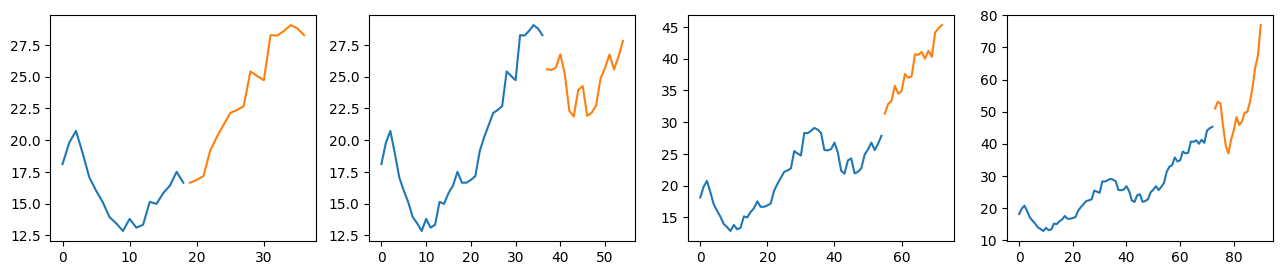

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

## Using TimeSeriesSplit from sklearn library
time_series_splits = TimeSeriesSplit(n_splits=4)
X = modelling_series.values
plt.figure(1)
fig = plt.figure(figsize=(24, 10))

index = 1
for train_index, test_index in time_series_splits.split(X):
 train = X[train_index]
 test = X[test_index]
 print('Observations: %d' % (len(train) + len(test)))
 print('Training Observations: %d' % (len(train)))
 print('Testing Observations: %d' % (len(test)))

 plt.subplot(360 + index)
 plt.plot(train)
 plt.plot([None for i in train] + [x for x in test])
    # pyplot.title(''.format())
 index += 1
plt.show()

In [67]:
import statsmodels.api as sm
def backtest_model(train,test):
    model = sm.tsa.SARIMAX(train,order=(2,2,0),seasonal_order=(2,2,0,12))
    results=model.fit()

    forecasts_train = results.predict(start=0,end=len(train))
    forecasts_test = results.predict(start=len(train),end=len(train)+len(test))


    fig,(ax1,ax2) = plt.subplots(2,figsize=(14,6))

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    forecasts_train = pd.DataFrame(forecasts_train)
    forecasts_test = pd.DataFrame(forecasts_test)

    forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
    train.plot(label='Actual',ax=ax1)
    ax1.set_ylabel('Stock Price')
    ax1.set_xlabel('Time')

    forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
    test.plot(label='Actual',ax=ax2)
    ax2.set_ylabel('Stock Price')
    ax2.set_xlabel('Time')

    ax1.legend()
    ax2.legend()
    plt.tight_layout(pad=2)

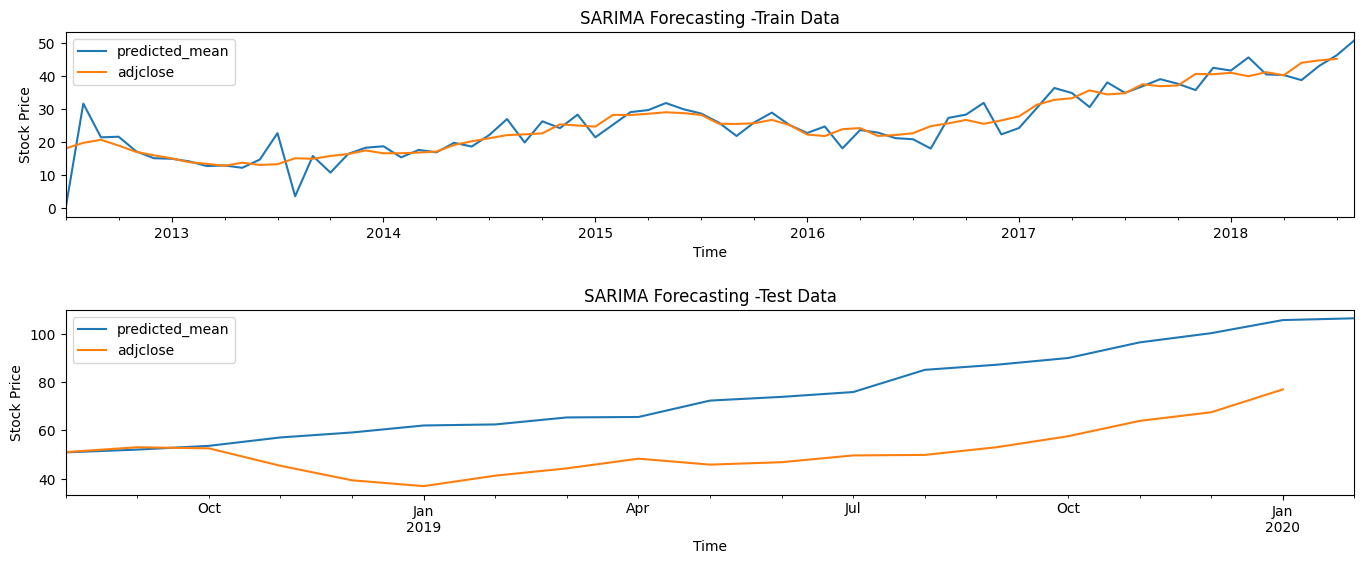

In [68]:
backtest_model(train,test)

In [58]:
modelling_series.index.min()

Timestamp('2012-07-31 00:00:00')

In [59]:
import pandas as pd

# Assuming modelling_series is your pandas Series or DataFrame
# Ensure the index of modelling_series is datetime-like
start_date = modelling_series.index.min()
end_date = modelling_series.index.max()

# Calculate the split point based on an 80-20 split
split_date = start_date + pd.DateOffset(days=int(0.8 * (end_date - start_date).days))

# Split the data into training and testing sets
train = modelling_series.loc[modelling_series.index < split_date]
test = modelling_series.loc[modelling_series.index >= split_date]

# Print start and end dates for train and test sets
print(f"Training Set: Start Date = {train.index.min()}, End Date = {train.index.max()}")
print(f"Testing Set: Start Date = {test.index.min()}, End Date = {test.index.max()}")


Training Set: Start Date = 2012-07-31 00:00:00, End Date = 2018-07-31 00:00:00
Testing Set: Start Date = 2018-08-31 00:00:00, End Date = 2020-01-31 00:00:00


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


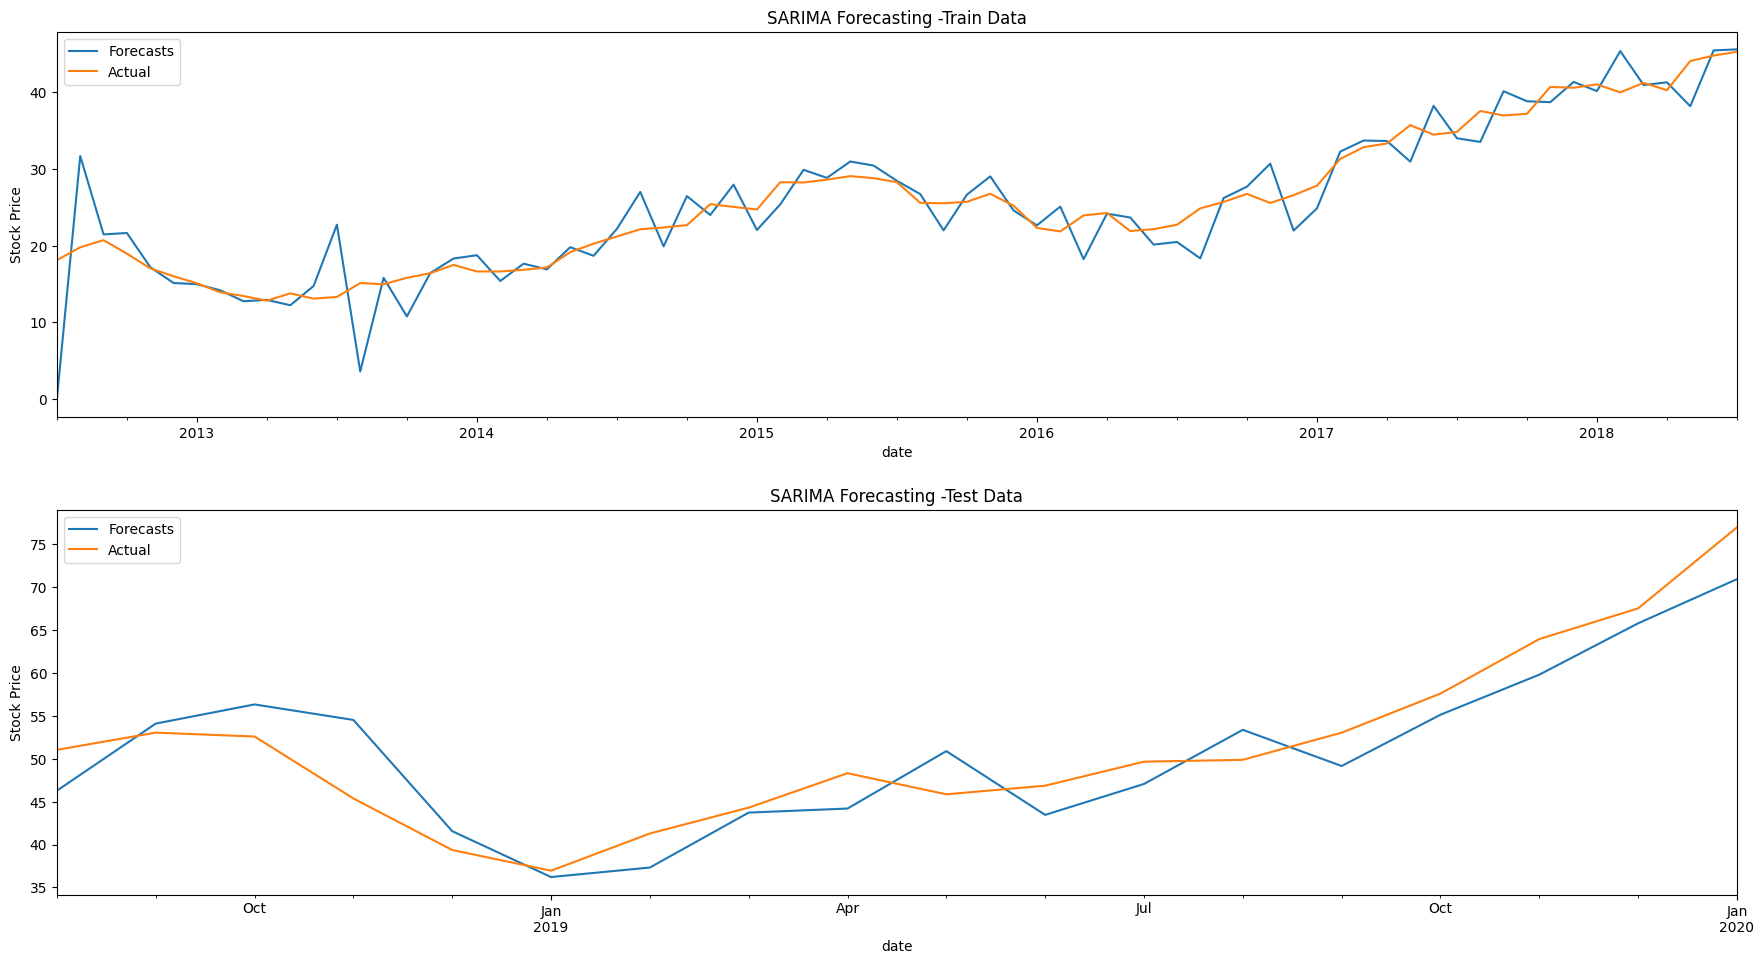

In [83]:
model = sm.tsa.SARIMAX(modelling_series,order=(2,2,1),seasonal_order=(1,2,2,12))
results=model.fit()
forecasts_train = results.predict(start='2012-07-31',end='2018-07-31')
forecasts_test = results.predict(start='2018-08-31',end='2020-01-31')

sd='2012-07-31'
ed='2018-07-31'
sd2='2018-08-31'
ed2='2020-01-31'

fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
modelling_series.loc[sd:ed].plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
modelling_series.loc[sd2:ed2].plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)

In [84]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
##Function to Calculate Result Metrics
def result_metrics(test_series,forecast_series,model_name):
  print('Result Metrics for {}'.format(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))

print(result_metrics(modelling_series[sd:ed],forecasts_train,'SARIMA-Train Data'))
print('----')
print(result_metrics(modelling_series[sd2:ed2],forecasts_test,'SARIMA-Test Data'))

Result Metrics for SARIMA-Train Data
R2 Score :  0.798
Mean Squared Error :  15.584
Mean Absolute Error :  2.506
None
----
Result Metrics for SARIMA-Test Data
R2 Score :  0.83
Mean Squared Error :  16.289
Mean Absolute Error :  3.504
None
